In [1]:
# %pip install numpy
# %pip install ipywidgets
# %pip install torch
# %pip install scikit-learn
# %pip install tensorflow
# %pip install pennylane
# %pip install opencv-python
# %pip install matplotlib
# %pip install kagglehub
# %pip install monai

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from monai.transforms import ScaleIntensity
import kagglehub
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import pennylane as qml
from pennylane import numpy as pnp

In [3]:
import warnings
warnings.filterwarnings("ignore")

#### Download dataset  https://www.kaggle.com/datasets/gurjeetkaurmangat/kidney-ultrasound-images-stone-and-no-stone

In [4]:
path = kagglehub.dataset_download("gurjeetkaurmangat/kidney-ultrasound-images-stone-and-no-stone")

# print("Path to dataset files:", path)

#### Define dataset paths
#### !!! Remove .DS_Store from folders

In [5]:
# !rm -rf f'{path}/my dataset final 512x512(implemented)/Normal/.DS_Store'
# !rm -rf f'{path}/my dataset final 512x512(implemented)/stone/.DS_Store'

In [6]:
dataset_path_normal = f'{path}/my dataset final 512x512(implemented)/Normal'
dataset_path_stone = f'{path}/my dataset final 512x512(implemented)/stone'

#### Count files in directory

In [7]:
def count_images(directory):
    return len([f for f in os.listdir(directory) if f.endswith(('.jpg', '.JPG', '.png', '.jpeg'))])

print("Length dataset_path_normal:", count_images(dataset_path_normal))
print("Length dataset_path_stone:", count_images(dataset_path_stone))

Length dataset_path_normal: 4414
Length dataset_path_stone: 5002


#### Check data

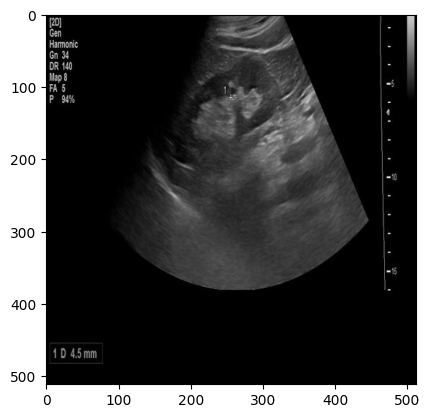

In [8]:
kid_image = cv2.imread(f'{dataset_path_stone}/Stone_6.JPG', cv2.IMREAD_GRAYSCALE)
plt.imshow(kid_image, cmap='gray')

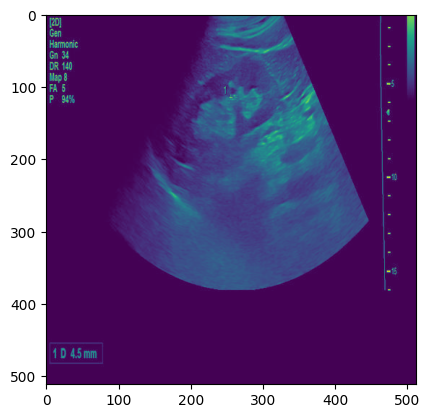

In [9]:
transform_img = ScaleIntensity(minv=0.0, maxv=1.0)
kid_image_scaled = transform_img(kid_image)
colored_kid = cm.viridis(kid_image_scaled)
plt.imshow(colored_kid)

#### Load and preprocess images

In [10]:
img_size = (224, 224)

def load_images_from_folder(folder, label, target_size=img_size):
    """
    Loads images from a given folder and resizes them to the specified target size.
    Converts images to RGB and stores them as numpy arrays (3D).

    Args:
        folder (str): Path to the folder containing images.
        label (int): Label associated with the images in the folder.
        target_size (tuple): Target size to which images will be resized (width, height).

    Returns:
        tuple: A list of image data and their corresponding labels.
    """
    data, labels = [], []
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path).convert("RGB").resize(target_size)
            data.append(np.array(img))
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")
    return np.array(data), np.array(labels)


def load_and_limit_data(path, label, num_samples, target_size=img_size):
    """
    Loads and limits the number of images from a folder to a specified number of samples.
    Ensures images are resized to the specified target size.

    Args:
        path (str): Path to the folder containing images.
        label (int): Label associated with the images in the folder.
        num_samples (int): Maximum number of samples to load.
        target_size (tuple): Target size to which images will be resized (width, height).

    Returns:
        tuple: A numpy array of limited image data and their corresponding labels.
    """
    data, labels = load_images_from_folder(path, label, target_size)
    indices = np.random.choice(len(data), min(num_samples, len(data)), replace=False)
    data = data[indices]
    labels = labels[indices]
    return data, labels

#### Display images for train

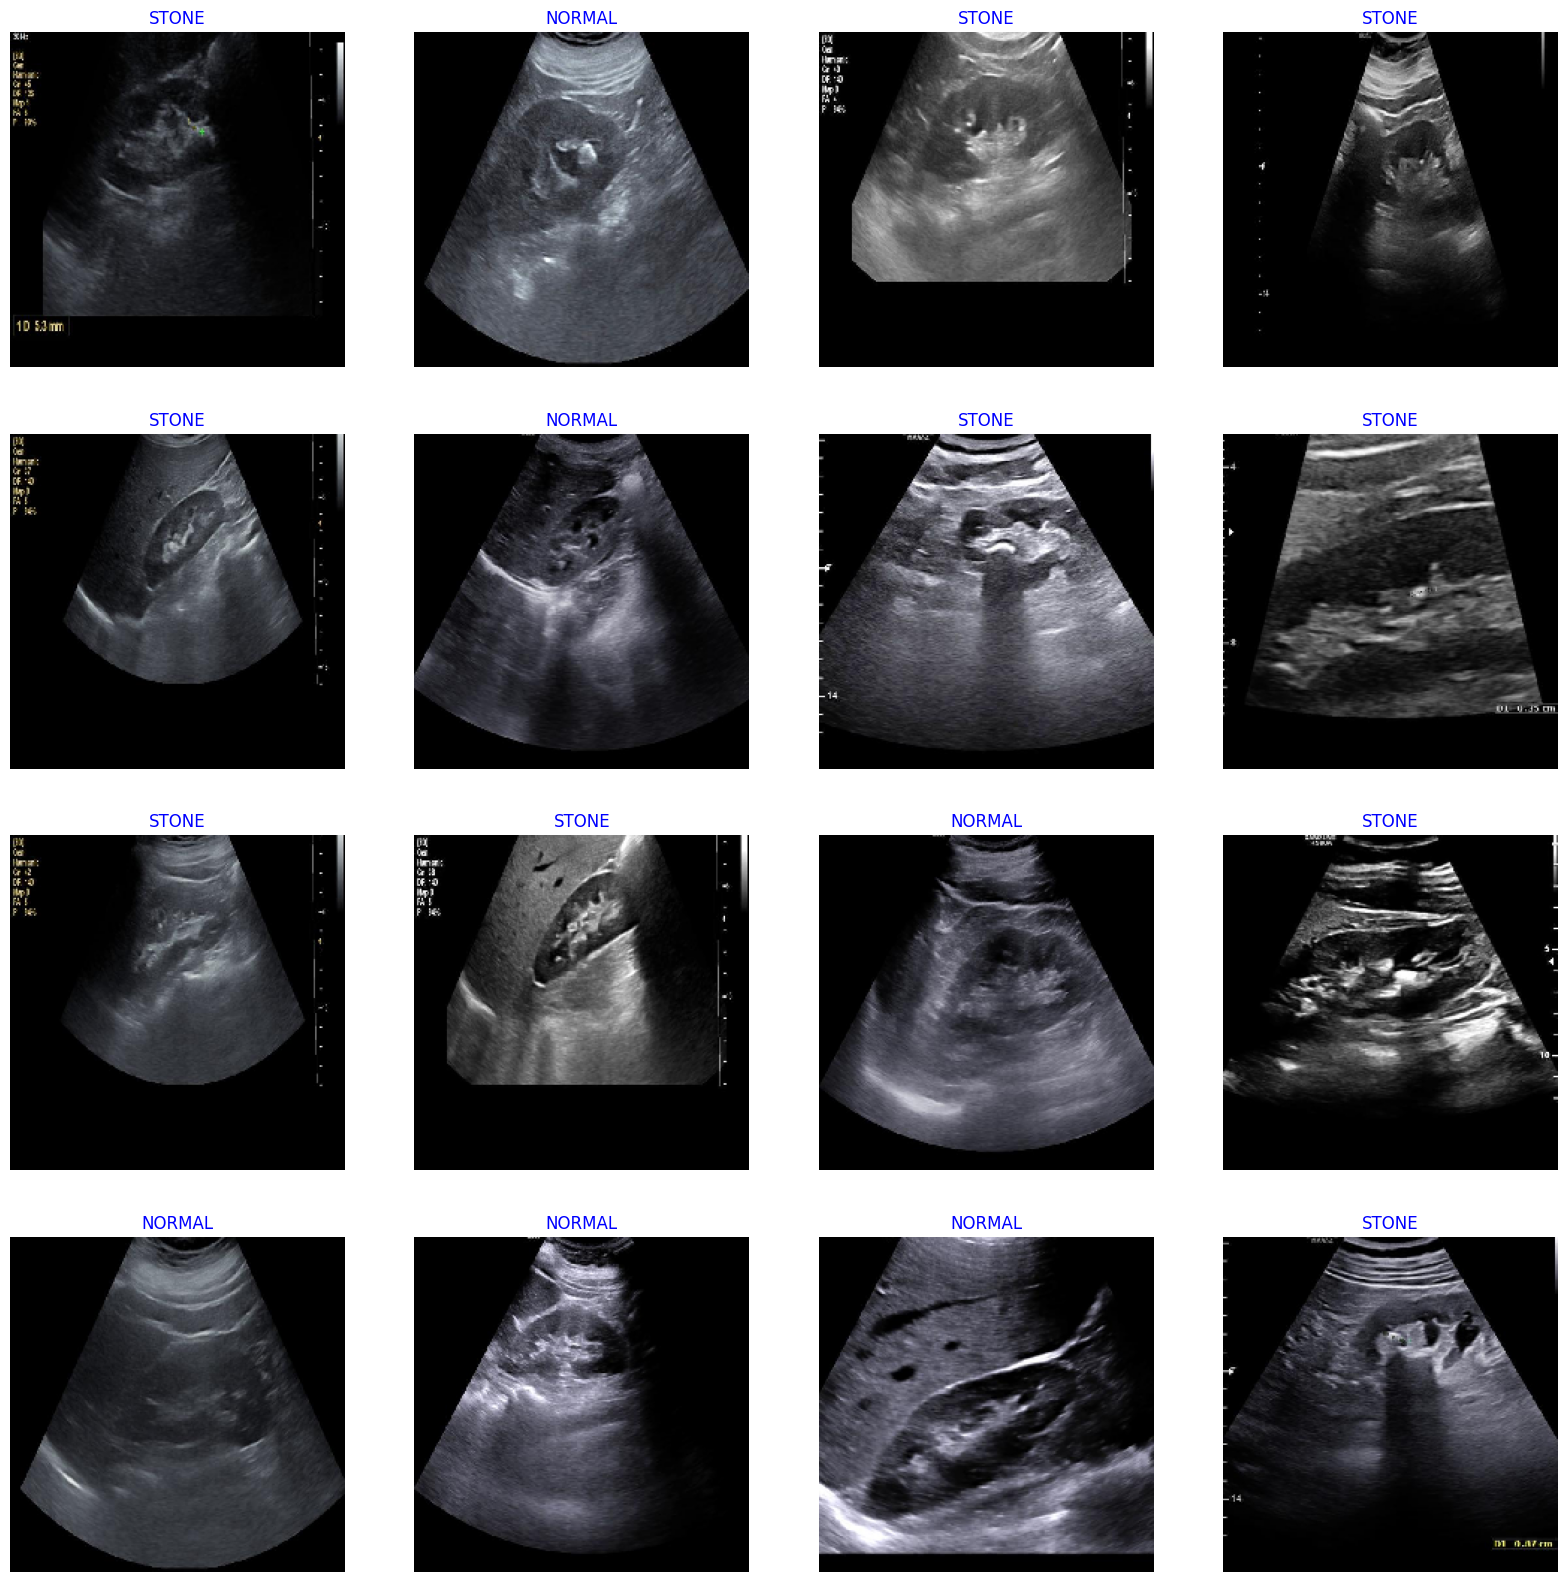

In [11]:
def load_file_paths_and_labels(directory, label):
    filepaths = [os.path.join(directory, fname) for fname in os.listdir(directory) if os.path.isfile(os.path.join(directory, fname))]
    labels = [label] * len(filepaths)
    return filepaths, labels

normal_filepaths, normal_labels = load_file_paths_and_labels(dataset_path_normal, 'NORMAL')
stone_filepaths, stone_labels = load_file_paths_and_labels(dataset_path_stone, 'STONE')

all_filepaths = stone_filepaths + normal_filepaths
all_labels = stone_labels + normal_labels

combined = list(zip(all_filepaths, all_labels))
np.random.shuffle(combined)
all_filepaths, all_labels = zip(*combined)

label_to_index = {'NORMAL': 0, 'STONE': 1}
categorical_labels = np.array([label_to_index[label] for label in all_labels])

def scalar(img):
    return img

def custom_generator(filepaths, labels, batch_size, img_size, preprocessing_function=None):
    while True:
        for i in range(0, len(filepaths), batch_size):
            batch_filepaths = filepaths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]
            
            images = []
            for filepath in batch_filepaths:
                img = load_img(filepath, target_size=img_size)
                img_array = img_to_array(img)
                if preprocessing_function:
                    img_array = preprocessing_function(img_array)
                images.append(img_array)
            
            yield np.array(images), np.array(batch_labels)

img_size = img_size
batch_size = 32

train_gen = custom_generator(all_filepaths, categorical_labels, batch_size, img_size, preprocessing_function=scalar)

images, labels = next(train_gen)

classes = list(label_to_index.keys())

plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    class_index = labels[i]
    class_name = classes[class_index]
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')

plt.show()

In [12]:
normal_data, normal_labels = load_and_limit_data(dataset_path_normal, label=0, num_samples=250)
stone_data, stone_labels = load_and_limit_data(dataset_path_stone, label=1, num_samples=400)

all_data = np.concatenate([normal_data, stone_data], axis=0)
all_labels = np.concatenate([normal_labels, stone_labels], axis=0)
X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.2, random_state=42)

#### The number of qubits

In [13]:
num_qubits = 4

#### Initial random weights for the quantum layer

In [14]:
weights = pnp.random.random(size=(3, num_qubits, 3), requires_grad=True)

#### Quantum device setup

In [15]:
dev = qml.device("default.qubit", wires=num_qubits)

@qml.qnode(dev, interface="torch")
def quantum_layer(inputs):
    qml.templates.AngleEmbedding(inputs, wires=range(num_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(num_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(num_qubits)]

#### Setting quantum model

In [16]:
class QuantumLayer(nn.Module):
    def forward(self, x):
        q_out = [torch.tensor(quantum_layer(x[i]), dtype=torch.float32) for i in range(x.shape[0])]
        return torch.stack(q_out)

class QuantumCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(QuantumCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.global_pool = nn.AdaptiveAvgPool2d((2, 2))
        self.flattened_size = 128 * 2 * 2

        self.quantum_layer = QuantumLayer()
        
        self.fc1 = nn.Linear(self.flattened_size + num_qubits, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.global_pool(x)
        x = x.reshape(x.size(0), -1)

        quantum_input = x[:, :num_qubits]
        q_out = self.quantum_layer(quantum_input)
        
        x = torch.cat((x, q_out), dim=1)

        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Initialize the model, criterion, optimizer

In [17]:
quantum_model = QuantumCNN(num_classes=2)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(quantum_model.parameters(), lr=0.001)

#### Training function

In [18]:
def fit_quantum_model(model, X_train, y_train, epochs=20, batch_size=32):
    model.train()
    history = {'loss': [], 'accuracy': []}

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    dataset = TensorDataset(X_train_tensor, y_train_tensor)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        epoch_loss = 0
        epoch_accuracy = 0

        for X_batch, y_batch in data_loader:
            optimizer.zero_grad()

            outputs = model(X_batch)

            loss = criterion(outputs, y_batch)
            epoch_loss += loss.item()

            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1) 
            acc = (predicted == y_batch).float().mean().item()
            epoch_accuracy += acc

        avg_epoch_loss = epoch_loss / len(data_loader)
        avg_epoch_accuracy = epoch_accuracy / len(data_loader)
        history['loss'].append(avg_epoch_loss)
        history['accuracy'].append(avg_epoch_accuracy)

        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_epoch_loss:.4f}, Accuracy: {avg_epoch_accuracy:.4f}")

    return history

#### Fit the model

In [19]:
quantum_history = fit_quantum_model(quantum_model, X_train, y_train, epochs=15)

Epoch [1/15], Loss: 0.4585, Accuracy: 0.7408
Epoch [2/15], Loss: 0.2134, Accuracy: 0.9265
Epoch [3/15], Loss: 0.1488, Accuracy: 0.9485
Epoch [4/15], Loss: 0.0917, Accuracy: 0.9632
Epoch [5/15], Loss: 0.0710, Accuracy: 0.9779
Epoch [6/15], Loss: 0.0910, Accuracy: 0.9596
Epoch [7/15], Loss: 0.1706, Accuracy: 0.9338
Epoch [8/15], Loss: 0.1570, Accuracy: 0.9338
Epoch [9/15], Loss: 0.0880, Accuracy: 0.9724
Epoch [10/15], Loss: 0.0463, Accuracy: 0.9798
Epoch [11/15], Loss: 0.0318, Accuracy: 0.9890
Epoch [12/15], Loss: 0.0330, Accuracy: 0.9908
Epoch [13/15], Loss: 0.0469, Accuracy: 0.9835
Epoch [14/15], Loss: 0.0495, Accuracy: 0.9871
Epoch [15/15], Loss: 0.0684, Accuracy: 0.9779


#### Plotting accuracy and loss

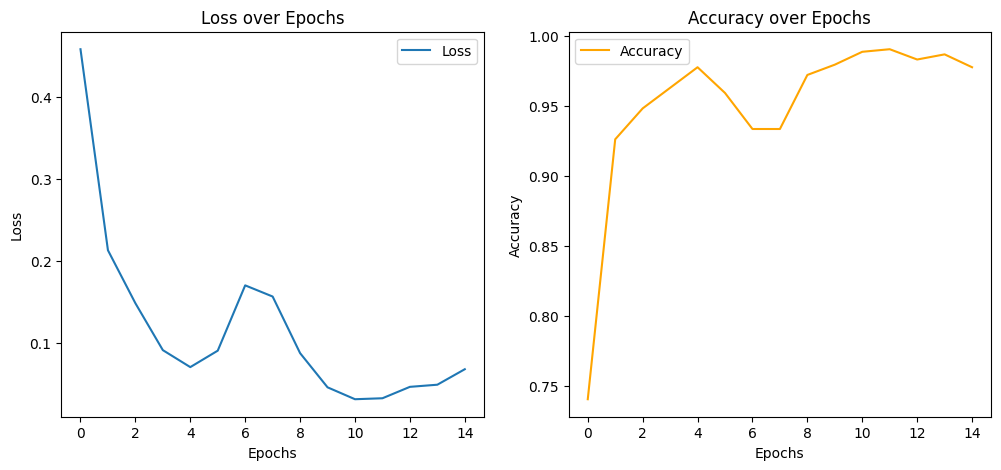

In [20]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(quantum_history['loss'], label='Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(quantum_history['accuracy'], label='Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#### The evaluation of model

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
quantum_model.to(device)

y_train_indices = torch.tensor(y_train, dtype=torch.long).to(device)  # Shape: (156,)
y_test_indices = torch.tensor(y_test, dtype=torch.long).to(device)    # Shape: (40,)

quantum_model.eval()
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
X_test_tensor = X_test_tensor.permute(0, 3, 1, 2)

with torch.no_grad():
    outputs = quantum_model(X_test_tensor)

y_pred = torch.argmax(outputs, dim=1).cpu().numpy()
y_test_labels = y_test_indices.cpu().numpy()

assert len(y_pred) == len(y_test_labels), "Predicted and true label arrays must have the same length."

test_accuracy = metrics.accuracy_score(y_test_labels, y_pred) * 100
classification_report = metrics.classification_report(
    y_test_labels, y_pred, target_names=['Normal', 'Stone##']
)

print(f"Test Accuracy: {test_accuracy:.2f}%")
print(classification_report)


Test Accuracy: 100.00%
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00        56
     Stone##       1.00      1.00      1.00        74

    accuracy                           1.00       130
   macro avg       1.00      1.00      1.00       130
weighted avg       1.00      1.00      1.00       130



#### Predicted probability for Positive Class

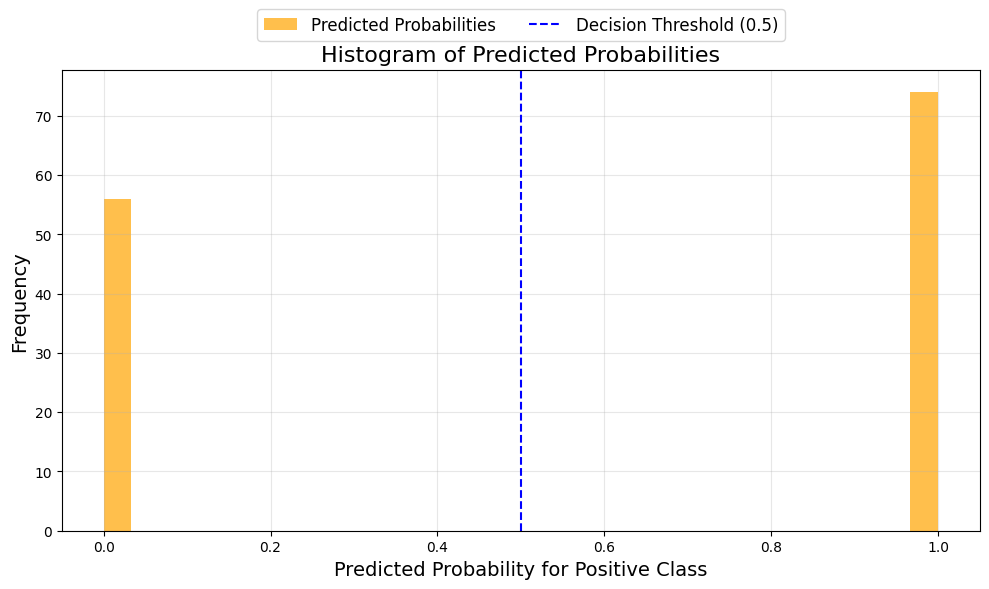

In [22]:
y_pred_probabilities_tensor = torch.tensor(y_pred, dtype=torch.float32)

y_pred_positive_probs = y_pred_probabilities_tensor

predictions = torch.round(y_pred_positive_probs)

plt.figure(figsize=(10, 6))

plt.hist(
    y_pred_positive_probs.numpy(),
    bins=30,
    alpha=0.7,
    color='orange',
    label='Predicted Probabilities'
)

plt.axvline(0.5, color='blue', linestyle='--', label='Decision Threshold (0.5)', linewidth=1.5)

plt.title('Histogram of Predicted Probabilities', fontsize=16)
plt.xlabel('Predicted Probability for Positive Class', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4, fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### PCA of model prediction

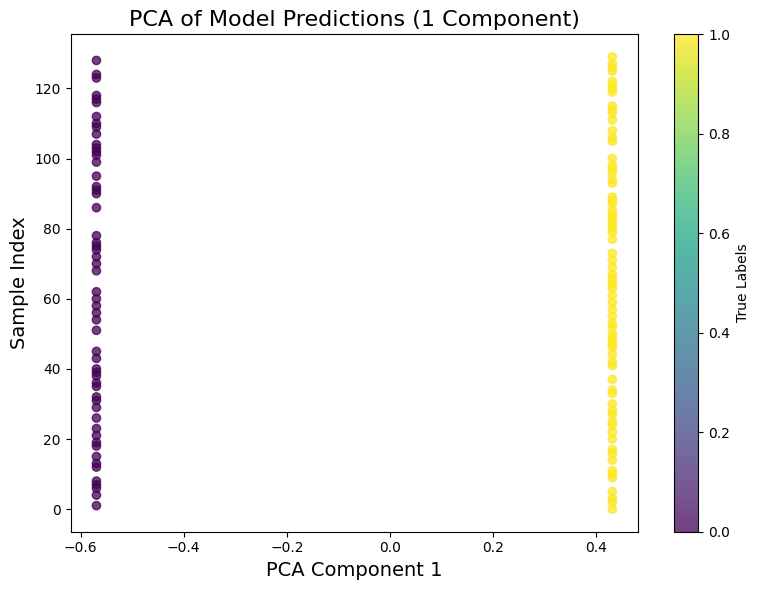

In [23]:
labels_test_reshaped = y_pred.reshape(-1, 1)

pca = PCA(n_components=1)
features_pca = pca.fit_transform(labels_test_reshaped)

plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], range(len(features_pca)), c=y_test_labels, cmap='viridis', alpha=0.75)

plt.colorbar(label='True Labels')
plt.title('PCA of Model Predictions (1 Component)', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('Sample Index', fontsize=14)

plt.tight_layout()
plt.show()

##### Plot the confusion matrix

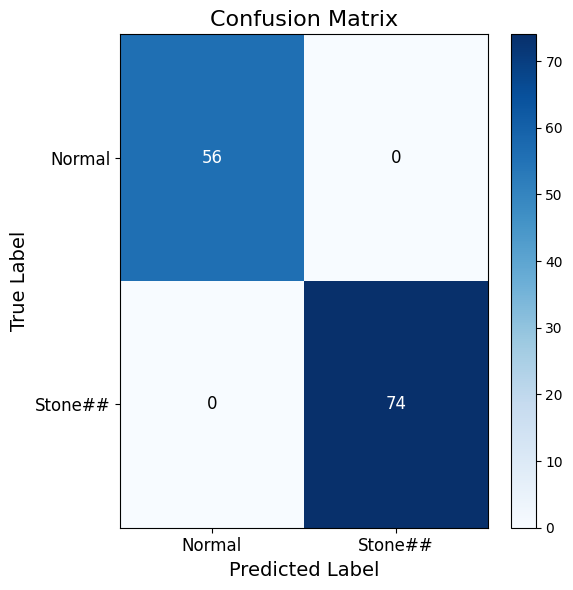

In [24]:
conf_matrix = confusion_matrix(y_test_labels, y_pred)

plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues, aspect='auto')
plt.title("Confusion Matrix", fontsize=16)
plt.colorbar()

plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)

classes = ['Normal', 'Stone##']
tick_marks = range(len(classes))
plt.xticks(tick_marks, classes, fontsize=12)
plt.yticks(tick_marks, classes, fontsize=12)

thresh = conf_matrix.max() / 2.0
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(
            j, i, f"{conf_matrix[i, j]}",
            ha="center", va="center",
            color="white" if conf_matrix[i, j] > thresh else "black",
            fontsize=12
        )

plt.tight_layout()
plt.show()
